In [ ]:
!pip install mne
!pip install torchsummary

In [1]:
import os
import numpy as np
import mne

mne.set_log_level("error")

import torch
import torch.nn as nn
from torch import no_grad
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Define google drive folder with example EEG Data
# drive_data_folder = ...
# from google.colab import drive
# drive.mount('/content/drive')
# %cd drive/MyDrive/{drive_data_folder}
%ls

 Volume in drive D is PC
 Volume Serial Number is 3AB1-5D3C

 Directory of d:\OneDrive\OneDrive - �budai egyetem\Programoz�s Gyakorl�s\MI\EEG GAN

2023. 05. 14.  12:35    <DIR>          .
2023. 05. 14.  12:35    <DIR>          ..
2023. 05. 14.  12:34        33�640�300 A01T.gdf
2023. 05. 14.  12:29                 0 debug.ipynb
2023. 05. 14.  10:22            10�386 DL feature extraction.ipynb
2023. 05. 14.  12:20                 0 model.py
2023. 05. 13.  17:28             2�594 model_og.py
2023. 05. 14.  11:19             4�070 train.py
2023. 05. 13.  17:28             3�942 train_og.py
2023. 05. 13.  17:47             1�170 utils.py
               8 File(s)     33�662�462 bytes
               2 Dir(s)  76�924�153�856 bytes free


In [2]:
#@title Config
MAPPING = {7: "feet", 8: "left_hand", 9: "right_hand", 10: "tongue"}

batch_size = 48
cfg = dict(
    preprocessing=dict(
        target_freq=100,
        low_freq=8,
        high_freq=25,
        average_ref=True,
        normalize = True
    ),
    epochs=dict(
        baseline=(-0.1, 1.9),
        tmin=-0.1,
        tmax=5.9,
    )
)

In [14]:
#@title Dataset

class MI_Dataset(Dataset):
    def __init__(self, subject_id, runs, device="cpu", config="default", verbose=False):
        self.subject_id = subject_id
        self.device = device
        self.runs = runs

        self.load_config()
        self.load_raw()
        self.apply_preprocess()
        self.create_epochs()
        if verbose:
            print(self.epochs)

        self.split_by_runs()
        self.format_data()

        self.time_steps = self.X.shape[-1]
        self.channels = self.X.shape[-2]
        
        if verbose:
            print("#" * 50)
            print("Dataset created:")
            print(f"X --> {self.X.shape} ({self.X.dtype})")
            print(f"y --> {self.y.shape} ({self.y.dtype})")
            print("#" * 50)

    def load_config(self):

        self.target_freq = cfg["preprocessing"]["target_freq"]
        self.low_freq = cfg["preprocessing"]["low_freq"]
        self.high_freq = cfg["preprocessing"]["high_freq"]
        self.average_ref = cfg["preprocessing"]["average_ref"]

        self.baseline = cfg["epochs"]["baseline"]
        self.tmin = cfg["epochs"]["tmin"]
        self.tmax = cfg["epochs"]["tmax"]

        self.normalize = cfg["preprocessing"]["normalize"]

    def load_raw(self):
        subject_path =  "A0" + str(self.subject_id) + "T.gdf"
        self.raw = mne.io.read_raw_gdf(subject_path, preload=True)
        self.filter_events()
        eog_channels = [
            i for i, ch_name in enumerate(self.raw.ch_names) if "EOG" in ch_name
        ]
        self.raw.drop_channels([self.raw.ch_names[ch_idx] for ch_idx in eog_channels])

    def filter_events(self):
        events, _ = mne.events_from_annotations(self.raw)
        annot_from_events = mne.annotations_from_events(
            events, event_desc=MAPPING, sfreq=self.raw.info["sfreq"]
        )

        self.raw.set_annotations(annot_from_events)

    def apply_preprocess(self):
        self.raw = self.raw.resample(self.target_freq, npad="auto")
        if self.average_ref:
            self.raw = self.raw.set_eeg_reference("average", projection=True)

        self.raw = self.raw.filter(l_freq=self.low_freq, h_freq=self.high_freq)

    def create_epochs(self):
        events, event_ids = mne.events_from_annotations(self.raw)
        self.epochs = mne.Epochs(
            self.raw,
            events=events,
            event_id=event_ids,
            tmin=self.tmin,
            tmax=self.tmax,
            baseline=self.baseline,
            preload=True,
        )
        self.epochs = self.epochs.crop(tmin=self.baseline[-1], tmax=self.tmax)
        self.epochs.plot()
        del self.raw

    def split_by_runs(self):
        X = self.epochs.get_data()

        if self.normalize:
            orig_shape = X.shape
            X = X.reshape(X.shape[0], -1)
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
            X = X.reshape(orig_shape)
            y = self.epochs.events[:, -1]
        y -= 1  # start at 0

        X_by_runs = []
        y_by_runs = []

        for index in range(0, int(X.shape[0] // 48)):
            X_by_runs.append(X[index * 48 : (index + 1) * 48])
            y_by_runs.append(y[index * 48 : (index + 1) * 48])

        self.runs_features = np.array(X_by_runs)
        self.runs_labels = np.array(y_by_runs)

        self.runs_features = self.runs_features[self.runs]
        self.runs_labels = self.runs_labels[self.runs]

        self.X = self.runs_features.reshape(
            -1, self.runs_features.shape[2], self.runs_features.shape[3]
        )
        self.y = self.runs_labels.reshape(-1)

    

    def format_data(self):
        self.X = torch.from_numpy(self.X).float()
        self.y = torch.from_numpy(self.y).long()

        self.X = self.X.to(self.device)
        self.y = self.y.to(self.device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [4]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

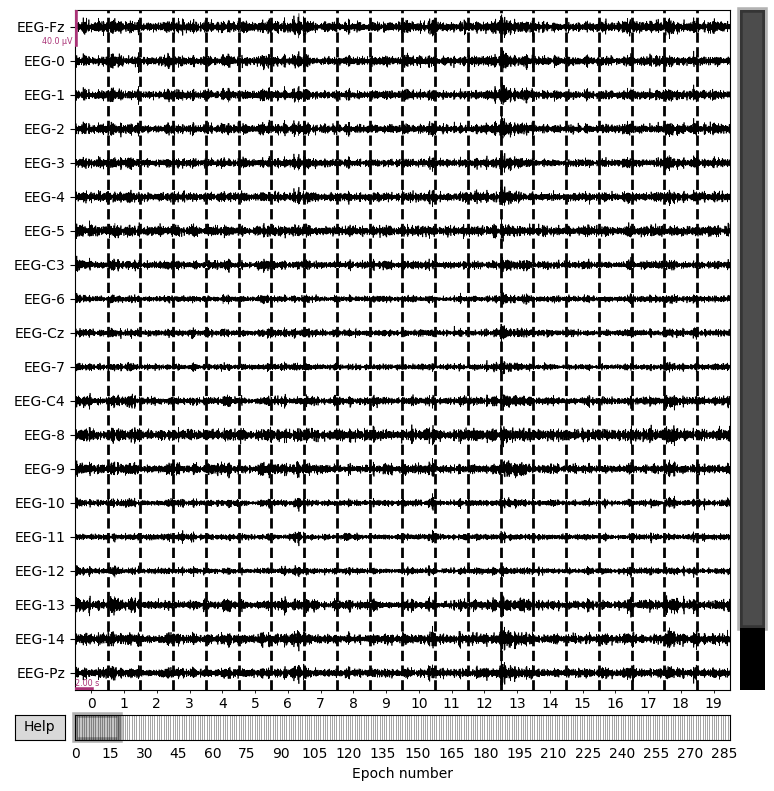

<Epochs |  288 events (all good), 1.9 – 5.9 s, baseline -0.1 – 1.9 s (baseline period was cropped after baseline correction), ~19.4 MB, data loaded,
 'feet': 72
 'left_hand': 72
 'right_hand': 72
 'tongue': 72>
##################################################
Dataset created:
X --> torch.Size([240, 22, 401]) (torch.float32)
y --> torch.Size([240]) (torch.int64)
##################################################


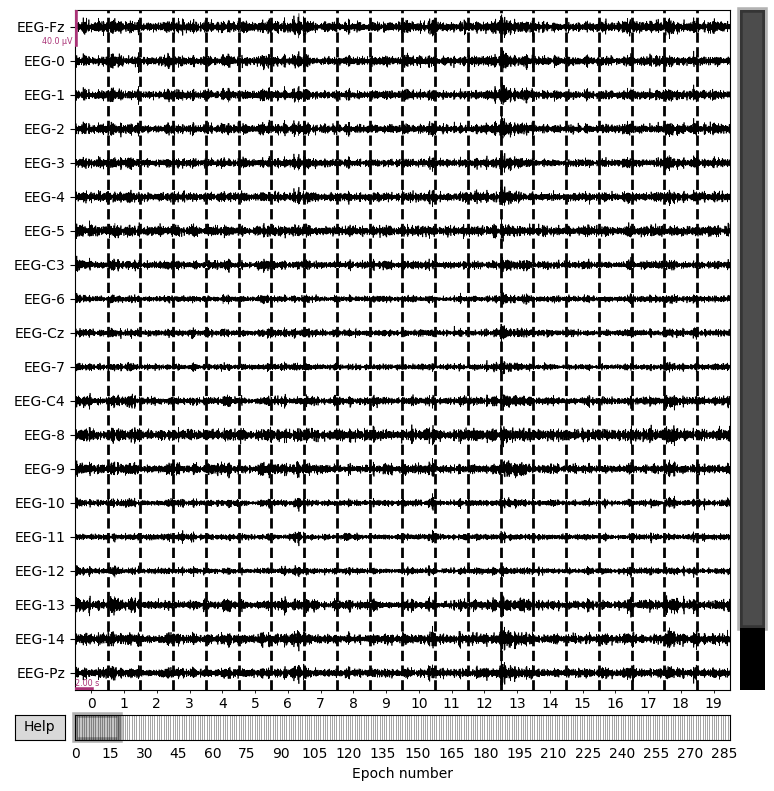

<Epochs |  288 events (all good), 1.9 – 5.9 s, baseline -0.1 – 1.9 s (baseline period was cropped after baseline correction), ~19.4 MB, data loaded,
 'feet': 72
 'left_hand': 72
 'right_hand': 72
 'tongue': 72>
##################################################
Dataset created:
X --> torch.Size([48, 22, 401]) (torch.float32)
y --> torch.Size([48]) (torch.int64)
##################################################


In [15]:
subject = 1
train_runs = [0,1,2,3,4]
test_runs = [5]


train_dataset = MI_Dataset(subject, train_runs, device = device, verbose = True)
test_dataset = MI_Dataset(subject, test_runs, device = device, verbose = True)

train_dataloader = DataLoader(train_dataset,  batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=True)

In [15]:
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

for features, label in train_dataloader:
    print(features.shape)
    print(label)
    break
    

Train dataset: 240 samples
Test dataset: 48 samples
torch.Size([48, 22, 401])
tensor([0, 2, 1, 1, 2, 3, 1, 1, 2, 3, 2, 1, 0, 0, 2, 2, 2, 0, 3, 0, 3, 1, 0, 3,
        0, 0, 2, 0, 1, 1, 2, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 2, 0, 0, 1, 2, 1, 0],
       device='cuda:0')


In [ ]:
'''
Implement EEGNet
https://arxiv.org/abs/1611.08024
'''


class EEGNet(nn.Module):
    def __init__(self,input_size,num_classes):
        super(EEGNet, self).__init__()
        ...
       

    def forward(self, x):
        ...
        return x

In [ ]:
'''
Train EEGNet
'''
